<a href="https://colab.research.google.com/github/sitirahmalatuconsina19/sitirahma-deplearning/blob/main/tugas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir /content/cnn

In [2]:
cp /content/drive/MyDrive/algoritmadeplearning/nnfl-cnn-lab2.zip /content/cnn

In [ ]:
!unzip /content/cnn/nnfl-cnn-lab2.zip

In [4]:
mv /content/upload /content/cnn

In [5]:
import numpy as np
import pandas as pd 
import random
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical 
from keras.layers import Input
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from PIL import Image

from keras.models import Sequential,Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalAveragePooling2D
from keras.optimizers import RMSprop
from keras.initializers import glorot_uniform 

In [6]:
df = pd.read_csv('/content/cnn/upload/train_set.csv')

In [7]:
df.head()

,image_name,label
0,0.jpg,0
1,1.jpg,4
2,2.jpg,5
3,4.jpg,0
4,7.jpg,4


In [8]:
df['label'] = df['label'].astype(str)
df.dtypes

image_name    object
label         object
dtype: object

<Axes: >

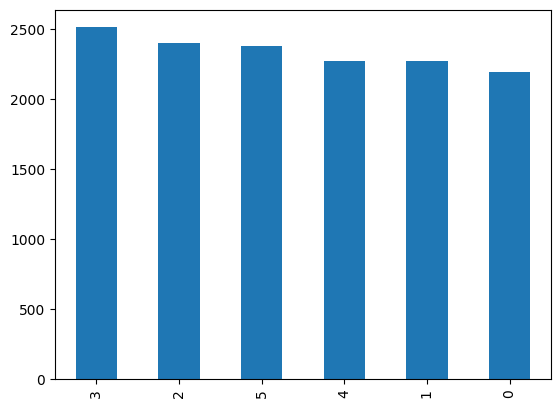

In [9]:
df['label'].value_counts().plot.bar()

(150, 150)


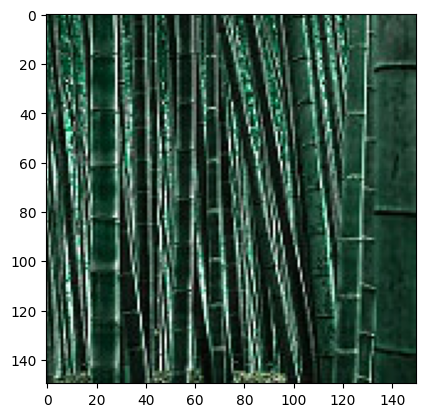

In [10]:
filenames = os.listdir('/content/cnn/upload/train_images/train_images/')
sample = random.choice(filenames)
image = load_img('/content/cnn/upload/train_images/train_images/'+sample)
plt.imshow(image)
print(image.size)

In [11]:
IMAGE_HEIGHT = 150
IMAGE_WIDTH = 150
IMAGE_CHANNELS = 3
IMAGE_SIZE = (IMAGE_HEIGHT,IMAGE_WIDTH)
batch_size = 15

In [12]:
def identity_block(X, f, filters, stage, block):
    
    
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    
    F1, F2, F3 = filters
    
    
    X_shortcut = X
    
   
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = Activation('relu')(X)
  
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = Activation('relu')(X)
   
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    
    return X
def convolutional_block(X, f, filters, stage, block, s = 2):
    
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
  
    F1, F2, F3 = filters
    
 
    X_shortcut = X


    
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = Activation('relu')(X)
   
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = Activation('relu')(X)
 
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)

    
    X_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)

    
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)    
    return X

def ResNet50(input_shape=(64, 64, 3), classes=6):

    
    X_input = Input(input_shape)


    X = ZeroPadding2D((3, 3))(X_input)

    X = Conv2D(128, (3, 3), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)
    X = convolutional_block(X, f=3, filters=[128, 128, 51], stage=2, block='a', s=1)
    X = AveragePooling2D((2,2), name="avg_pool")(X)

  

   
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model
model = ResNet50(input_shape = (150, 150, 3), classes = 6)
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 156, 156, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1 (Conv2D)                 (None, 77, 77, 128)  3584        ['zero_padding2d[0][0]']         
                                                                                                  
 activation (Activation)        (None, 77, 77, 128)  0           ['conv1[0][0]']           

In [13]:
earlystop = EarlyStopping(patience=60)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
Checkpoint = ModelCheckpoint('temp.h5', monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', period=1)
callbacks = [earlystop, learning_rate_reduction,Checkpoint]

In [14]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

<Axes: >

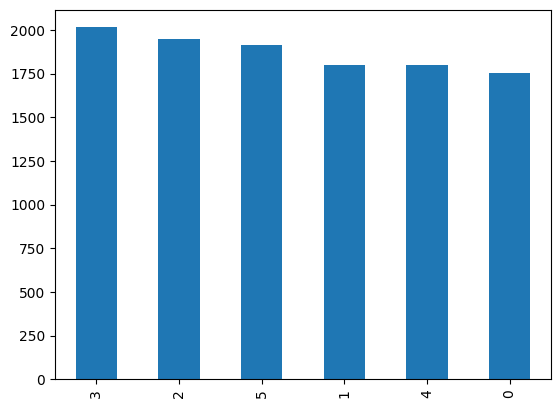

In [15]:
train_df['label'].value_counts().plot.bar()

<Axes: >

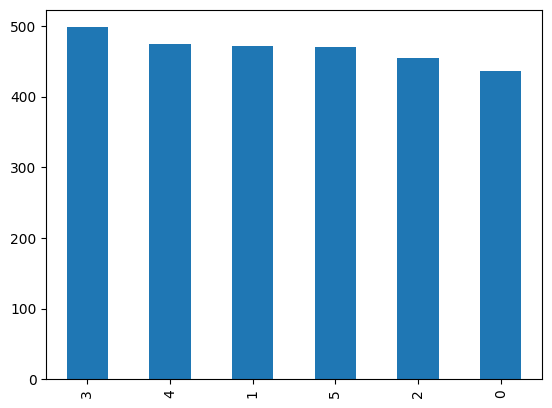

In [16]:
validate_df['label'].value_counts().plot.bar()

In [17]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
print(total_train, total_validate)

11227 2807


In [18]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "/content/cnn/upload/train_images/train_images/", 
    x_col='image_name',
    y_col='label',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 11227 validated image filenames belonging to 6 classes.


In [19]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "/content/cnn/upload/train_images/train_images/", 
    x_col='image_name',
    y_col='label',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 2807 validated image filenames belonging to 6 classes.


In [20]:
epochs=20
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/20


<ipython-input-20-8d4bf705bda3>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


748/748 [==============================] - ETA: 0s - loss: 1.1237 - accuracy: 0.5685
Epoch 1: val_accuracy improved from -inf to 0.66774, saving model to temp.h5
748/748 [==============================] - 94s 108ms/step - loss: 1.1237 - accuracy: 0.5685 - val_loss: 0.9018 - val_accuracy: 0.6677 - lr: 0.0010
Epoch 2/20
748/748 [==============================] - ETA: 0s - loss: 0.8531 - accuracy: 0.6888
Epoch 2: val_accuracy improved from 0.66774 to 0.74938, saving model to temp.h5
748/748 [==============================] - 82s 110ms/step - loss: 0.8531 - accuracy: 0.6888 - val_loss: 0.7079 - val_accuracy: 0.7494 - lr: 0.0010
Epoch 3/20
748/748 [==============================] - ETA: 0s - loss: 0.7873 - accuracy: 0.7173
Epoch 3: val_accuracy did not improve from 0.74938
748/748 [==============================] - 79s 105ms/step - loss: 0.7873 - accuracy: 0.7173 - val_loss: 0.7469 - val_accuracy: 0.7308 - lr: 0.0010
Epoch 4/20
748/748 [==============================] - ETA: 0s - loss: 0.72

In [21]:
model.load_weights('temp.h5')

In [22]:
model.save_weights("model.h5")

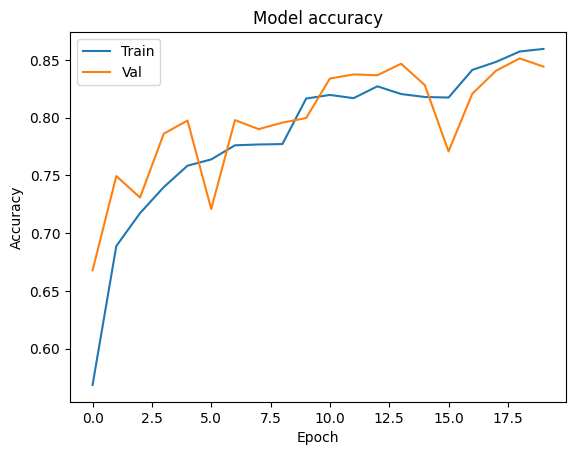

In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

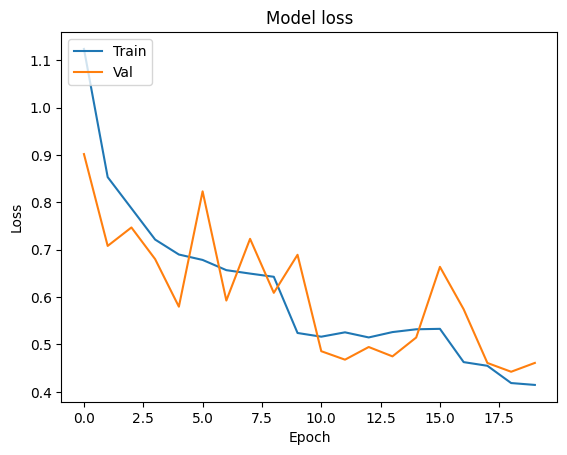

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [26]:
validation_generator = validation_datagen.flow_from_dataframe(
    pd.DataFrame(validate_df), 
    "/content/cnn/upload/train_images/train_images/", 
    x_col='image_name',
    y_col='label',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle = False
)
y_pred = [np.argmax(a) for a in (model.predict_generator(validation_generator))]

Found 2807 validated image filenames belonging to 6 classes.


<ipython-input-26-355c4b927ea1>:11: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = [np.argmax(a) for a in (model.predict_generator(validation_generator))]


In [27]:
f1_score(y_pred,validate_df['label'].astype(int), average = 'micro')

0.8510865692910581

In [28]:
confusion_matrix(y_pred,validate_df['label'].astype(int))

array([[389,  10,   9,   3,   9,  73],
       [  2, 445,   8,   4,   0,   7],
       [  4,   0, 362,  67,  20,   2],
       [  3,   7,  64, 405,  32,   3],
       [  3,   2,  10,  18, 409,   6],
       [ 36,   8,   2,   1,   5, 379]])

In [29]:
test_df = pd.read_csv('/content/cnn/upload/sample_submission.csv')

In [30]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    test_df, 
    "/content/cnn/upload/test_images/test_images/", 
    x_col='image_name',
    y_col=None,
    target_size=IMAGE_SIZE,
    class_mode=None,
    batch_size=batch_size,
    shuffle = False
)
nb_samples = test_df.shape[0]

Found 7301 validated image filenames.


In [31]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

<ipython-input-31-52619fd72ccc>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))


In [33]:
test_df['label'] = np.argmax(predict, axis = -1)

In [34]:
test_df.head()

,image_name,label
0,3.jpg,5
1,5.jpg,0
2,6.jpg,4
3,11.jpg,4
4,14.jpg,5


<Axes: >

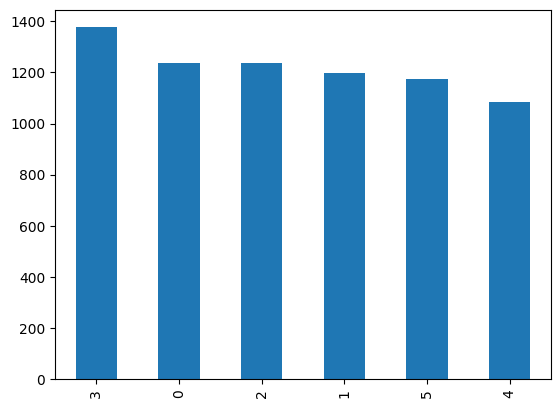

In [35]:
test_df['label'].value_counts().plot.bar()

In [36]:
submission_df = test_df.copy()
submission_df['image_name'] = submission_df['image_name']
submission_df['label'] = submission_df['label']
submission_df.image_name = submission_df.image_name.apply(str)
#submission_df.drop(['filename', 'category'], axis=1, inplace=True)
print(submission_df.head())
submission_df.to_csv('submission.csv', index=False)

  image_name  label
0      3.jpg      5
1      5.jpg      0
2      6.jpg      4
3     11.jpg      4
4     14.jpg      5


In [37]:
from IPython.display import HTML
import pandas as pd
import numpy as np
import base64
def create_download_link(df, title = "Download CSV file", filename = "data.csv"):
    csv = df.to_csv(index=False)
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html) 
create_download_link(submission_df) 